# 修士論文実験 2022/01/10
# 追記 2022/01/17
## validationが簡単に行えるようにデータセットを操作するモジュールを拡充

In [221]:
import os
import sys
import csv
import math
import json
import glob
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import interpolate
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

%matplotlib inline
writer = SummaryWriter()

# sys.path.append(os.path.abspath(".."))
# import scripts.compensate
# import scripts.kinectImg2video
# from scripts.conpemsate_suppresser import *
# from scripts.ground_angle_analysis import ground_shoulder_angle_analyzer
# import scripts.ground_angle_analysis

In [222]:
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [223]:
# 日付の追加
df_annotate = pd.read_excel("/Users/kento/kuhp/experiment/annotate_dataset.xlsx")
df_annotate['date'] = pd.to_datetime(df_annotate['date'], format='%Y-%m-%d-%H-%M-%S')

In [53]:
df_annotate.head()

,date,uid,subject_id,task_id,point,shoulder,body,flag_usage
0,2021-12-06 18:56:20,1,1,1,3,0,0,1
1,2021-12-06 18:56:20,2,1,1,4,0,0,2
2,2021-12-06 18:56:41,3,1,1,3,0,0,1
3,2021-12-06 18:56:41,4,1,1,4,0,0,2
4,2021-12-06 18:56:58,5,1,1,3,0,0,1


In [54]:
# DataSetの呼び出し
df_data = pd.read_csv("/Users/kento/kuhp/experiment/bigdata_trimmed.csv")
df_data['date'] = pd.to_datetime(df_data['date'], format='%Y-%m-%d-%H-%M-%S')
df_data.head()

,Unnamed: 0,Unnamed: 0.1,id,x_Pelvis,y_Pelvis,z_Pelvis,x_SpineNaval,y_SpineNaval,z_SpineNaval,x_SpineChest,...,x_REar,y_REar,z_REar,N,v_RWrist,z_v_RWrist,flag_active,flag_moving,timestamp,date
0,0,0,1.0,-158.973129,353.261841,698.233093,-149.886017,218.100922,780.778748,-142.035919,...,-178.933960,-236.272278,842.268127,NaN,NaN,-0.917988,0.0,1.0,0.000000,2021-12-04 18:20:18
1,1,1,1.0,-156.911919,356.031863,697.378637,-147.957493,219.063530,781.238292,-142.348493,...,-176.788628,-241.853940,862.009244,NaN,7.131710,0.480634,1.0,1.0,39.891892,2021-12-04 18:20:18
2,2,2,1.0,-157.406120,356.970863,697.867036,-148.184343,219.214968,781.799317,-142.899719,...,-176.093690,-243.703880,867.831643,NaN,5.690953,0.198082,1.0,1.0,79.783784,2021-12-04 18:20:18
3,3,3,1.0,-159.493486,356.687710,699.214911,-149.753131,218.849632,782.412353,-143.553739,...,-176.457427,-243.071735,864.096621,NaN,6.280899,0.313779,1.0,1.0,119.675676,2021-12-04 18:20:18
4,4,4,1.0,-162.211771,355.791270,700.938883,-151.850422,218.261918,783.027933,-144.174692,...,-177.488121,-241.207140,855.165480,NaN,6.247976,0.307322,1.0,1.0,159.567568,2021-12-04 18:20:18


In [55]:
# pd_merged = pd.merge(df_annotate, df_data, on='date', how='inner')
# pd_3 = pd_merged[pd_merged['point'] == 3]
# pd_2A = pd_merged[pd_merged['point'] == '2A']
# pd_2B = pd_merged[pd_merged['point'] == '2B']
# pd_2C = pd_merged[pd_merged['point'] == '2C']

### このデータセットはGraspのものかつ，usageが1のものが取り出されている

In [56]:
# データセットにNN入力用のスコアを割り振る．
# これが正解ラベルになる
dataset = pd.merge(df_annotate, df_data, on='date', how='inner')

dataset = dataset[(dataset['task_id'] == 1) & (dataset['flag_usage'] == 1)]
dataset['point'] = dataset['point'].astype(str)
dataset.loc[dataset['point'] == '3', 'score'] = 3
dataset.loc[dataset['point'] == '2A', 'score'] = 2
dataset.loc[dataset['point'] == '2B', 'score'] = 1
dataset.loc[dataset['point'] == '2C', 'score'] = 0
print(dataset['score'].max())

# Nanのものを削除
dataset.dropna(subset=['score'], inplace=True)
# scoreの行をintにする
dataset['score'] = dataset['score'].astype(int)

3.0


In [57]:
dataset['uid'].unique()
dataset['date'].unique().shape

(47,)

In [58]:
# Grasp動作だけを抜き出す
# dataset_grasp = dataset[dataset['task_id'] == 1]

## RElbow2RWrist と Rshoulder2RElbow と Pelvis2RShoulder と Pelvis2Neck の速度を入れてみる 

In [59]:
# df_annotate
# l_date = df_annotate['date'].values

In [60]:
def add_vector(df, joint1, joint2, word=""):
    df[f"{word}_x_{joint1}2{joint2}"] = df[f"x_{joint1}"].astype('float64') - df[f"x_{joint2}"].astype('float64')
    df[f"{word}_y_{joint1}2{joint2}"] = df[f"y_{joint1}"].astype('float64') - df[f"y_{joint2}"].astype('float64')
    df[f"{word}_z_{joint1}2{joint2}"] = df[f"z_{joint1}"].astype('float64') - df[f"z_{joint2}"].astype('float64')
    df[f"{word}_ave_{joint1}2{joint2}"] = (df[f"{word}_x_{joint1}2{joint2}"] + df[f"{word}_y_{joint1}2{joint2}"] + df[f"{word}_z_{joint1}2{joint2}"])/3
    return df

In [61]:
# l_date_name = np.array(dataset['date'].unique())
# l = []
# for date in l_date_name:
#     score = dataset[dataset["date"] == date]['score'].mode()
#     l.append(score)
# return np.array(l)

In [107]:
# 正解ラベルで用いるyのone hotベクトルを作成
def one_hot_enc(df):
    l = []
    l_date_name = np.array(df['date'].unique())
    for date in l_date_name:
        score = df[df["date"] == date]['score'].mode()
        l.append(score)
    y = np.array(l).flatten()
    
    # l_date_name = np.array(df['date'].unique())
    # y = np.array(df["score"]) #一番多いものをscoreとして最後にyとして返す
    # y_arr = np.ones(l_date_name.shape)
    # y_arr = y_arr * y
    return y

def interpolate1(array):
    x_old = np.linspace(0, 1, array.shape[0])
    y_old = array
    
    f = interpolate.interp1d(x_old, y_old)

    x = np.linspace(0, 1, 100)
    y_new = f(x)
    return y_new

def zscore(x, axis = 1):
    xmean = x.mean(axis=axis, keepdims=True)
    xstd  = np.std(x, axis=axis, keepdims=True)
    zscore = (x-xmean)/xstd
    return zscore

In [108]:
# ara = np.array([[[1,2,3,4,5],[4,5,6,7,8],[7,8,9,10,11]]])
# ara.shape
# z = zscore(ara)
# print(z.shape)
# print(ara)
# print(z)

In [109]:
# この関数を実行しさえすればデータセットが作成される
def create_Xy(dataset):
    #正解ラベルの作成
    y = one_hot_enc(dataset)
    
    # Xの作成
    l_date_name = np.array(dataset['date'].unique())
    for k, date in enumerate(l_date_name):
        #一連のデータ，1サンプル
        series = dataset[dataset['date'] == l_date_name[k]]
        series.drop(columns='point', inplace=True)
        series.drop(columns='date', inplace=True)
        #差分ベクトルを取得
        diff = series.diff()
        diff.fillna(0, inplace=True)

        # 間接点同士のベクトルのカラムをデータフレームに追加
        # これらがデータセットになる
        diff = add_vector(diff, 'RElbow', "RWrist", 'v')
        diff = add_vector(diff, 'RShoulder', "RElbow", 'v')
        diff = add_vector(diff, 'Pelvis', "RShoulder", 'v')
        diff = add_vector(diff, 'Pelvis', "Neck", 'v')
        diff = add_vector(diff, 'Neck', 'RShoulder', 'v')
        diff = add_vector(diff, 'Neck', 'LShoulder', 'v')
        
        # arr_data = diff.loc[:, columns].values
        arr_data = diff.loc[:, "v_x_RElbow2RWrist":].values
        
        # 補間を行う
        for i in range(arr_data.shape[1]):
            tmp_interpolate = interpolate1(arr_data[:, i])
            # print(tmp_interpolate.shape)
            #二次元に拡張
            tmp_interpolate = tmp_interpolate.reshape(tmp_interpolate.shape[0], 1)
            if i == 0:
                x = tmp_interpolate
            else:
                x = np.concatenate([x, tmp_interpolate],1)
                
        # サンプル数の次元を拡張する
        x = x.reshape(1, x.shape[0], x.shape[1])
        
        #最初だけ条件分岐
        if k == 0:
            X = x
        else:
            X = np.concatenate([X, x], axis=0)
        
       # 最後にzscore変換
        X = zscore(X)
    return X, y

# validation用に1人のデータを検証データに回す

In [183]:
train_df = dataset[~(dataset['subject_id'] == 3)]
val_df = dataset[dataset['subject_id'] == 3]

In [184]:
X_train, y_train = create_Xy(train_df)
X_val, y_val = create_Xy(val_df)

/Users/kento/miniforge3/envs/torch/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [ ]:
print(X.shape)
print(y.shape)

torch.Size([35, 101, 24])
torch.Size([35, 4])


In [ ]:
# (X_3, y_3) = create_Xy(pd_3)
# (X_2, y_2) = create_Xy(pd_2A)
# (X_1, y_1) = create_Xy(pd_2B)
# (X_0, y_0) = create_Xy(pd_2C)

In [ ]:
#DataSetの結合
# x_train = np.concatenate([X_3, X_2, X_1, X_0])
# y_train = np.concatenate([y_3, y_2, y_1, y_0])
# y_train = y_train.astype('int64')
# x_test = np.concatenate([X_3, X_2, X_1, X_0])
# y_test = np.concatenate([y_3, y_2, y_1, y_0])
# y_test = y_test.astype('int64')

In [188]:
x_train = X_train
y_train = y_train
y_train = y_train.astype('int64')
x_test = X_val
y_test = y_val
y_test = y_test.astype('int64')

In [189]:
n_classes = len(np.unique(y_train))
print(n_classes)

y_train_onehot = np.identity(n_classes)[y_train]
y_test_onehot = np.identity(n_classes)[y_test]
# print(y_train_onehot)

4


## PyTorchのdatasetの作成


In [190]:
### 先頭にclassification用のトークンを追加する
score_train = np.zeros((x_train.shape[0], 1 , x_train.shape[2]))
x_train = np.concatenate([score_train, x_train], axis=1)

score_test = np.zeros((x_test.shape[0], 1 , x_test.shape[2]))
x_test = np.concatenate([score_test, x_test], axis=1)

In [191]:
X = torch.tensor(x_train, dtype=torch.float32)
y = torch.tensor(y_train_onehot, dtype=torch.int8)

X_val = torch.tensor(x_test, dtype=torch.float32)
y_val = torch.tensor(y_test_onehot, dtype=torch.int8)

In [192]:
train_dataset = torch.utils.data.TensorDataset(X, y)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1)

val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=1)

In [193]:
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

In [194]:
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

## Build the model

Our model processes a tensor of shape `(batch size, sequence length, features)`,
where `sequence length` is the number of time steps and `features` is each input
timeseries.

You can replace your classification RNN layers with this one: the
inputs are fully compatible!

We include residual connections, layer normalization, and dropout.
The resulting layer can be stacked multiple times.

The projection layers are implemented through `keras.layers.Conv1D`.

In [195]:
class PositionalEncoder(nn.Module):
    '''入力された単語の位置を示すベクトル情報を付加する'''

    def __init__(self, d_model=12, max_seq_len=256):
        super().__init__()

        self.d_model = d_model  # 単語ベクトルの次元数

        # 単語の順番（pos）と埋め込みベクトルの次元の位置（i）によって一意に定まる値の表をpeとして作成
        pe = torch.zeros(max_seq_len, d_model)

        # GPUが使える場合はGPUへ送る、ここでは省略。実際に学習時には使用する
        # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        # pe = pe.to(device)

        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/d_model)))
                
                # 誤植修正_200510 #79
                # pe[pos, i + 1] = math.cos(pos /
                #                          (10000 ** ((2 * (i + 1))/d_model)))
                pe[pos, i + 1] = math.cos(pos /
                                          (10000 ** ((2 * i)/d_model)))

        # 表peの先頭に、ミニバッチ次元となる次元を足す
        self.pe = pe.unsqueeze(0)

        # 勾配を計算しないようにする
        self.pe.requires_grad = False

    def forward(self, x):
        # 入力xとPositonal Encodingを足し算する
        # xがpeよりも小さいので、大きくする
        ret = math.sqrt(self.d_model)*x + self.pe
        return ret


In [196]:
class Attention(nn.Module):
    def __init__(self, d_model=4):
        super().__init__()

        # SAGANでは1dConvを使用したが、今回は全結合層で特徴量を変換する
        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)

        # 出力時に使用する全結合層
        self.out = nn.Linear(d_model, d_model)

        # Attentionの大きさ調整の変数
        self.d_k = d_model

    def forward(self, q, k, v, mask):
        # 全結合層で特徴量を変換
        k = self.k_linear(k)
        q = self.q_linear(q)
        v = self.v_linear(v)

        # Attentionの値を計算する
        # 各値を足し算すると大きくなりすぎるので、root(d_k)で割って調整
        weights = torch.matmul(q, k.transpose(1, 2)) / math.sqrt(self.d_k)

        # ここでmaskを計算
        # mask = mask.unsqueeze(1)
        # print(mask)
        # weights = weights.masked_fill(mask == 0, -1e9)

        # softmaxで規格化をする
        normlized_weights = F.softmax(weights, dim=-1)

        # AttentionをValueとかけ算
        output = torch.matmul(normlized_weights, v)

        # 全結合層で特徴量を変換
        output = self.out(output)

        return output, normlized_weights


In [197]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=1024, dropout=0.1):
        '''Attention層から出力を単純に全結合層2つで特徴量を変換するだけのユニットです'''
        super().__init__()

        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        x = self.linear_1(x)
        x = self.dropout(F.relu(x))
        x = self.linear_2(x)
        return x

In [198]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, dropout=0.1):
        super().__init__()

        # LayerNormalization層
        # https://pytorch.org/docs/stable/nn.html?highlight=layernorm
        self.norm_1 = nn.LayerNorm(d_model)
        self.norm_2 = nn.LayerNorm(d_model)

        # Attention層
        self.attn = Attention(d_model)

        # Attentionのあとの全結合層2つ
        self.ff = FeedForward(d_model)

        # Dropout
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)

    def forward(self, x, mask):
        # 正規化とAttention
        # print(f"input shape is {x.shape}")
        x_normlized = self.norm_1(x)
        output, normlized_weights = self.attn(
            x_normlized, x_normlized, x_normlized, mask)
        
        x2 = x + self.dropout_1(output)

        # 正規化と全結合層
        x_normlized2 = self.norm_2(x2)
        output = x2 + self.dropout_2(self.ff(x_normlized2))
        # print(f"output shape is {output.shape}")

        return output, normlized_weights


In [199]:
class ScoringHead(nn.Module):
    '''Transformer_Blockの出力を使用して，最後にスコアリングを行う'''
    
    def __init__(self, d_model=300, output_dim=4):
        super().__init__()

        # 全結合層
        self.linear = nn.Linear(d_model, output_dim)  # output_dimはポジ・ネガの2つ
        self.output_dim = output_dim

        # 重み初期化処理
        nn.init.normal_(self.linear.weight, std=0.02)
        nn.init.normal_(self.linear.bias, 0)

    def forward(self, x):
        x0 = x[:, 0, :]  # 各ミニバッチの各文の先頭の単語の特徴量（300次元）を取り出す
        x1 = self.linear(x0)
        out = F.softmax(x1, dim=-1)

        return out

In [200]:
class ClassificationHead(nn.Module):
    '''Transformer_Blockの出力を使用し、最後にクラス分類させる'''

    def __init__(self, d_model=300, output_dim=4):
        super().__init__()

        # 全結合層
        self.linear = nn.Linear(d_model, output_dim)  # output_dimはポジ・ネガの2つ
        self.output_dim = output_dim

        # 重み初期化処理
        nn.init.normal_(self.linear.weight, std=0.02)
        nn.init.normal_(self.linear.bias, 0)

    def forward(self, x):
        x0 = x[:, 0, :]  # 各ミニバッチの各文の先頭の単語の特徴量（300次元）を取り出す
        x1 = self.linear(x0)
        # print(x1.shape)
        out = F.softmax(x1, dim=-1)

        return out


In [201]:
# 最終的なTransformerモデルのクラス

class TransformerClassification(nn.Module):
    '''Transformerでクラス分類させる'''

    def __init__(self, d_model=12, max_seq_len=101, output_dim=4):
        super().__init__()

        # モデル構築
        self.net_Positional = PositionalEncoder(d_model=d_model, max_seq_len=max_seq_len)
        self.net_Attention_1 = TransformerBlock(d_model=d_model)
        # self.net3_2 = TransformerBlock(d_model=d_model)
        self.net_Classification = ClassificationHead(output_dim=output_dim, d_model=d_model)

    def forward(self, x, mask):
        x1 = self.net_Positional(x)  # Positon情報を足し算
        x2, normlized_weights_1 = self.net_Attention_1(x1, mask)  # Self-Attentionで特徴量を変換
        # x3_2, normlized_weights_2 = self.net3_2(x3_1, mask)  # Self-Attentionで特徴量を変換
        x3 = self.net_Classification(x2)  # 最終出力の0単語目を使用して、分類0-1のスカラーを出力
        return x3, normlized_weights_1


# validation用に1人のデータを検証データに回す

In [293]:
train_df = dataset[~(dataset['subject_id'] == 3)]
val_df = dataset[dataset['subject_id'] == 3]

In [294]:
X_train, y_train = create_Xy(train_df)
X_val, y_val = create_Xy(val_df)

In [295]:
print(X.shape)
print(y.shape)

torch.Size([35, 101, 24])
torch.Size([35, 4])


In [296]:
x_train = X_train
y_train = y_train
y_train = y_train.astype('int64')
x_test = X_val
y_test = y_val
y_test = y_test.astype('int64')

In [297]:
n_classes = len(np.unique(y_train))
print(n_classes)

y_train_onehot = np.identity(n_classes)[y_train]
y_test_onehot = np.identity(n_classes)[y_test]
# print(y_train_onehot)

4


## PyTorchのdatasetの作成


In [298]:
### 先頭にclassification用のトークンを追加する
score_train = np.zeros((x_train.shape[0], 1 , x_train.shape[2]))
x_train = np.concatenate([score_train, x_train], axis=1)

score_test = np.zeros((x_test.shape[0], 1 , x_test.shape[2]))
x_test = np.concatenate([score_test, x_test], axis=1)

In [299]:
X = torch.tensor(x_train, dtype=torch.float32)
y = torch.tensor(y_train_onehot, dtype=torch.int8)

X_val = torch.tensor(x_test, dtype=torch.float32)
y_val = torch.tensor(y_test_onehot, dtype=torch.int8)

In [300]:
train_dataset = torch.utils.data.TensorDataset(X, y)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1)

val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=1)

In [301]:
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

In [1]:
# Setup seeds
np.random.seed(1234)
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

NameError: name 'np' is not defined

## Train and evaluate

In [303]:
# 動作確認
# ミニバッチの用意
batch = next(iter(train_dataloader))

# モデル構築
net = TransformerClassification(
    d_model=24, max_seq_len=101, output_dim=4)

# 入出力
x = batch[0]
input_pad = 1
input_mask = (x != input_pad)
out, normlized_weights_1 = net(x, input_mask)

print("出力のテンソルサイズ：", out.shape)
print("出力テンソルのsigmoid：", F.softmax(out, dim=1))


出力のテンソルサイズ： torch.Size([1, 4])
出力テンソルのsigmoid： tensor([[0.2036, 0.3161, 0.2714, 0.2089]], grad_fn=<SoftmaxBackward0>)


The main part of our model is now complete. We can stack multiple of those
`transformer_encoder` blocks and we can also proceed to add the final
Multi-Layer Perceptron classification head. Apart from a stack of `Dense`
layers, we need to reduce the output tensor of the `TransformerEncoder` part of
our model down to a vector of features for each data point in the current
batch. A common way to achieve this is to use a pooling layer. For
this example, a `GlobalAveragePooling1D` layer is sufficient.

In [304]:
# ネットワークの初期化を定義

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        # Liner層の初期化
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)

# 訓練モードに設定
net.train()

# TransformerBlockモジュールを初期化実行
net.net_Attention_1.apply(weights_init)
# net.net3_2.apply(weights_init)


print('ネットワーク設定完了')

ネットワーク設定完了


In [305]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()
# nn.LogSoftmax()を計算してからnn.NLLLoss(negative log likelihood loss)を計算

# 最適化手法の設定
learning_rate = 3e-4
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [306]:
# モデルを学習させる関数を作成
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)
    print('-----start-------')
    # ネットワークをGPUへ
    net.to(device)

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # epochのループ
    for epoch in range(num_epochs):
        # epochごとの訓練と検証のループ
        for phase in ['train', 'val']:
        # for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # データローダーからミニバッチを取り出すループ
            for batch in (dataloaders_dict[phase]):
                # batchはTextとLableの辞書オブジェクト

                # GPUが使えるならGPUにデータを送る
                inputs = batch[0].to(device)  # 文章
                labels = batch[1].to(device)  # ラベル

                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):

                    # mask作成
                    input_pad = 1  # 単語のIDにおいて、'<pad>': 1 なので
                    input_mask = (inputs != input_pad)

                    # Transformerに入力
                    outputs, _ = net(inputs, input_mask)
                    # print(f"outputs shape is {outputs.dtype}, label shape is {labels.float()}")
                    loss = criterion(outputs, labels.float())  # 損失を計算

                    _, preds = torch.max(outputs, 1)  # ラベルを予測

                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # 結果の計算
                    # print(np.array(preds))
                    # print(np.array(np.argmax(labels.data)))
                    # print(preds == labels.data)
                    epoch_loss += loss.item() * inputs.size(0)  # lossの合計を更新
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == np.argmax(labels.data))

            if phase == 'train':
                writer.add_scalar("Loss/train", loss, epoch)
            else:
                writer.add_scalar("Loss/test", loss, epoch)

            # epochごとのlossと正解率
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)
            # print(epoch_corrects.double())
            # print(len(dataloaders_dict[phase].dataset))

            print('Epoch {}/{} | {:^5} |  Loss: {:.4f} Acc: {:.4f}'.format(epoch+1, num_epochs,
                                                                           phase, epoch_loss, epoch_acc))

    return net


In [307]:
# # グリッドサーチを行う．
# l_rate = [2e-4, 3e-4, 4e-4, 5e-4]

# for learning_rate in l_rate:
#     print(learning_rate)
#     # 訓練モードに設定
#     net.train()

#     # TransformerBlockモジュールを初期化実行
#     net.net_Attention_1.apply(weights_init)
#     net.net_Classification.apply(weights_init)
    
#     num_epochs = 300
#     optimizer = optim.Adam(net.parameters(), lr=learning_rate)
#     net_trained = train_model(net, dataloaders_dict,
#                           criterion, optimizer, num_epochs=num_epochs)

In [312]:
# 学習・検証を実行する 15分ほどかかります

# 訓練モードに設定
net.train()


# 損失関数の設定
criterion = nn.CrossEntropyLoss()
# nn.LogSoftmax()を計算してからnn.NLLLoss(negative log likelihood loss)を計算

# 最適化手法の設定
learning_rate = 1e-4
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

# TransformerBlockモジュールを初期化実行
np.random.seed(1234)
random.seed(1234)
torch.manual_seed(1234)
troch.cuda.manual_seed(1234)
net.net_Attention_1.apply(weights_init)
print('ネットワーク設定完了')

num_epochs = 70
net_trained = train_model(net, dataloaders_dict,
                          criterion, optimizer, num_epochs=num_epochs)
writer.flush()

ネットワーク設定完了
使用デバイス： cpu
-----start-------
Epoch 1/70 | train |  Loss: 1.4264 Acc: 0.2778
Epoch 1/70 |  val  |  Loss: 1.3767 Acc: 0.2727
Epoch 2/70 | train |  Loss: 1.4219 Acc: 0.2222
Epoch 2/70 |  val  |  Loss: 1.3304 Acc: 0.3636
Epoch 3/70 | train |  Loss: 1.3801 Acc: 0.2778
Epoch 3/70 |  val  |  Loss: 1.3126 Acc: 0.3636
Epoch 4/70 | train |  Loss: 1.3752 Acc: 0.3333
Epoch 4/70 |  val  |  Loss: 1.3024 Acc: 0.4545
Epoch 5/70 | train |  Loss: 1.3679 Acc: 0.3889
Epoch 5/70 |  val  |  Loss: 1.3074 Acc: 0.4545
Epoch 6/70 | train |  Loss: 1.3236 Acc: 0.4722
Epoch 6/70 |  val  |  Loss: 1.2959 Acc: 0.4545
Epoch 7/70 | train |  Loss: 1.3578 Acc: 0.4444
Epoch 7/70 |  val  |  Loss: 1.2907 Acc: 0.4545
Epoch 8/70 | train |  Loss: 1.3376 Acc: 0.3611
Epoch 8/70 |  val  |  Loss: 1.2831 Acc: 0.4545
Epoch 9/70 | train |  Loss: 1.3258 Acc: 0.4167
Epoch 9/70 |  val  |  Loss: 1.2836 Acc: 0.4545
Epoch 10/70 | train |  Loss: 1.3090 Acc: 0.4722
Epoch 10/70 |  val  |  Loss: 1.2720 Acc: 0.4545
Epoch 11/70 | tra

# SaveModel

In [215]:
# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net_trained.eval()   # モデルを検証モードに
net_trained.to(device)

epoch_corrects = 0  # epochの正解数

# test_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=60)
test_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=60)

for batch in (test_dataloader):  # testデータのDataLoader
    # batchはTextとLableの辞書オブジェクト
    
    # GPUが使えるならGPUにデータを送る
    inputs = batch[0].to(device)  # 文章
    labels = batch[1].to(device)  # ラベル

    # 順伝搬（forward）計算
    with torch.set_grad_enabled(False):

        # mask作成
        input_pad = 1  # 単語のIDにおいて、'<pad>': 1 なので
        input_mask = (inputs != input_pad)

        # Transformerに入力
        outputs, attn_weights1 = net_trained(inputs, input_mask)
        _, preds = torch.max(outputs, 1)  # ラベルを予測

        # 結果の計算
        # 正解数の合計を更新
        # print(torch.argmax(labels.data, ))
        epoch_corrects += torch.sum(preds == torch.argmax(labels.data, dim=1))

# 正解率
epoch_acc = epoch_corrects.double() / len(test_dataloader.dataset)

print('テストデータ{}個での正解率：{:.4f}'.format(len(test_dataloader.dataset),epoch_acc))


テストデータ36個での正解率：0.9722


[3 3 3 2 1 2 1 1 1 0 0 0 3 3 3 2 2 2 1 1 1 0 0 0 3 3 3 2 2 2 1 1 1 0 0 0]
[3 3 3 2 2 2 1 1 1 0 0 0 3 3 3 2 2 2 1 1 1 0 0 0 3 3 3 2 2 2 1 1 1 0 0 0]
[[9 0 0 0]
 [0 9 0 0]
 [0 1 8 0]
 [0 0 0 9]]


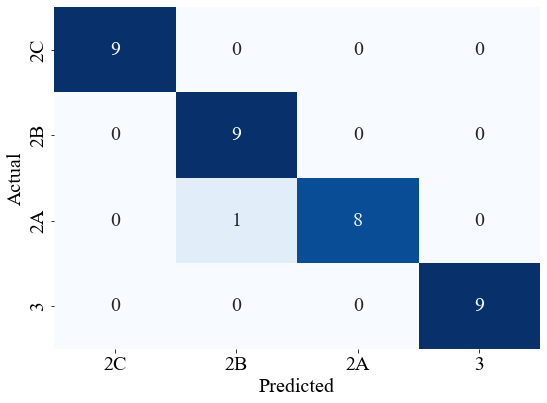

In [216]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


preds_heat = np.array(preds)
trues_heat = np.array(torch.argmax(labels.data, dim=1))
# preds_heat[0] = "3A"
print(preds_heat)
print(trues_heat)

heat = confusion_matrix(trues_heat, preds_heat)
print(heat)

plt.rcParams["font.family"] = "Times New Roman"   # 使用するフォント
plt.rcParams["font.size"] = 20        

fig, ax = plt.subplots(figsize=(8, 6))
xtics = ["2C", "2B", "2A", "3"]
ytics = ["2C", "2B", "2A", "3"]
# Set the palette using the name of a palette:
sns.heatmap(heat, annot=True, xticklabels=xtics, yticklabels=ytics, cmap="Blues", cbar=False)
# sns.heatmap(heat, annot=True, cmap="Blues", cbar=False)
#*以下2行がポイント*  X,Y軸ラベルを追加
plt.xlabel("Predicted")
plt.ylabel("Actual")
#グラフをはみ出さないようにして画面に出力
plt.tight_layout()
fig.savefig("nn-heatmap_3.pdf")
plt.show()

In [ ]:
print(X.shape)
print(np.array(X[0, 1:, 0]).shape)

In [ ]:
extract_weight = np.array(attn_weights1[15, 0, 1:]).reshape(1, -1)

fig, ax = plt.subplots(figsize=(20, 1))
# Set the palette using the name of a palette:
sns.heatmap(extract_weight, cmap='OrRd')
plt.show()

In [ ]:
from matplotlib import gridspec

extract_data = np.array(X[19, 1:, 2]).flatten()
print(extract_data.shape)


time = np.linspace(0, 100, 100)
fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [6, 1]}, figsize=(15,10))
# Set the palette using the name of a palette:
sns.lineplot(time, extract_data, ax=ax[0])
sns.heatmap(extract_weight, cmap='OrRd', cbar=False, ax=ax[1])

plt.show()

In [ ]:
import seaborn as sns

data = np.array(attn_weights1[:, 0, :])
print(data.shape)
data = data.reshape(attn_weights1.shape[0], -1)

# print(outputs)
print(data.shape)

fig, ax = plt.subplots(figsize=(30, 20))
# Set the palette using the name of a palette:
sns.heatmap(data, cmap='OrRd')
plt.show()

In [ ]:
for i in range(len(data[0])):
    print(data[0,i], end=',')

In [ ]:
net_trained.net_Attention_1

In [ ]:
# modelの読み込みだけ
# 保存したモデルパラメータの読み込み
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net_trained = TransformerClassification().to(device)

net_trained.load_state_dict(torch.load('highacc2.pth'))
# print('読み込み後のモデル:\n', model2.state_dict())

In [ ]:
torch.save(net_trained.state_dict(), 'highacc3.pth')

# 新しいモデル
model2 = TransformerClassification().to(device)
print('新しいモデル:\n', model2.state_dict())

# 保存したモデルパラメータの読み込み
model2.load_state_dict(torch.load('highacc3.pth'))
print('読み込み後のモデル:\n', model2.state_dict())

# attention weight の保存

In [ ]:
data.shape
print(data)
print(data.reshape(-1))

In [ ]:
# 同時に入れるデータも作成する
# これは時系列スタンプ．0〜100がサンプル数だけ作られる
stamp_row = [i%data.shape[1] for i in range(data.shape[0] * data.shape[1])]

# いつ撮影されたのかのスタンプ
l_date_name = np.array(df_annotate['date'].unique())
date_row = []
for item in l_date_name:
    for i in range(data.shape[1]):
        date_row.append(item)
        
# アテンションウエイト
attn_weight = data.reshape(-1)

In [ ]:
df_attn = pd.DataFrame()
df_attn['date'] = date_row
df_attn["stamp"] = stamp_row
df_attn["attn_weight"] = attn_weight

In [ ]:
df_attn.to_excel('/Users/kento/kuhp/experiment/attention_validate_weights.xlsx')

In [ ]:
type(df_attn['date'][0])